In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
from sklearn.model_selection import train_test_split,KFold,StratifiedKFold,GridSearchCV,RandomizedSearchCV,cross_val_score
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier,AdaBoostClassifier,GradientBoostingClassifier,RandomForestRegressor,BaggingRegressor,AdaBoostRegressor,GradientBoostingRegressor
from sklearn.linear_model import LinearRegression,LogisticRegression,Lasso, Ridge
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier,KNeighborsRegressor
import sklearn.metrics as metrics
from sklearn.metrics import r2_score,roc_auc_score,classification_report,mean_squared_error,accuracy_score,confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [2]:
df=pd.read_csv('D:/datasets+minipro/Analytics vidhya free course material/Regression/bigmartanalytics.csv')

## Linear Regression Assumptions:

In [121]:
# Converting data to numeric and imputing null values to apply base model.

In [122]:
df1=df.copy()
df1.drop('Item_Identifier',1,inplace=True)
### Converting Incorrect classes,typos into same class in df1.
df1['Item_Fat_Content'].replace({'LF':'Low Fat','low fat':'Low Fat','reg':'Regular'},inplace=True)
## Label encoding
from sklearn.impute import SimpleImputer
si=SimpleImputer(missing_values=np.nan, strategy='median')
sicate=SimpleImputer(missing_values=np.nan, strategy='most_frequent')
for i in df1.select_dtypes(include='object'):
    if df1[i].isnull().sum()>0:
        df1[i]=sicate.fit_transform(np.array(df1[i]).reshape(-1,1))
for i in df1.select_dtypes(exclude='object'):
    if df1[i].isnull().sum()>0:
        df1[i]=si.fit_transform(np.array(df1[i]).reshape(-1,1))
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
for i in df1.select_dtypes(include='object'):
    df1[i]=le.fit_transform(df1[i])

# Lets build base model first:[OLS using stats]
import statsmodels.api as sm
X=df1.drop('Item_Outlet_Sales',1)
y=df1['Item_Outlet_Sales']
Xc=sm.add_constant(X)
model = sm.OLS(y, Xc).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Item_Outlet_Sales   R-squared:                       0.510
Model:                            OLS   Adj. R-squared:                  0.510
Method:                 Least Squares   F-statistic:                     887.3
Date:                Wed, 20 May 2020   Prob (F-statistic):               0.00
Time:                        10:12:28   Log-Likelihood:                -72480.
No. Observations:                8523   AIC:                         1.450e+05
Df Residuals:                    8512   BIC:                         1.451e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                      -976.5102   3203.359     -0.305      0.760   -7255.871    5302.851
Item_Weight                  -0.3629      3.065     -0.118      0.906      -6.371       5.645
Item_Fat_Content             56.1508     27.388      2.050      0.040       2.465     109.837
Item_Visibility           -1391.6602    258.815     -5.377      0.000   -1898.999    -884.321
Item_Type                    -0.8539      3.109     -0.275      0.784      -6.948       5.240
Item_MRP                     15.5850      0.208     74.917      0.000      15.177      15.993
Outlet_Identifier            59.8204      9.291      6.438      0.000      41.607      78.034
Outlet_Establishment_Year     0.1742      1.608      0.108      0.914      -2.978       3.326
Outlet_Size                -339.2174     28.229    -12.017      0.000    -394.553    -283.882
Outlet_Location_Type       -222.3644     38.565     -5.766      0.000    -297.961    -146.767
Outlet_Type                 880.4369     26.436     33.305      0.000     828.617     932.257
==============================================================================
Omnibus:                      856.969   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1786.710
Skew:                           0.643   Prob(JB):                         0.00
Kurtosis:                       4.837   Cond. No.                     4.96e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.96e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

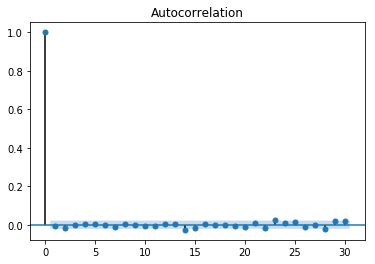

In [123]:
#### 1 - Autocorrelation :
# As we can observe that base model is not giving good accuracy in terms of r2 score.
# we can also see that durbin-watson score is good enough(Approx close to 2)meaning that there is no autocorrelation
# between residuals
import statsmodels.tsa.api as smt
acf = smt.graphics.plot_acf(model.resid, lags=30 , alpha=0.05)
acf.show()
# So, we can see that all lines are within blue boundary indicating that there is almost no autocorrelation
# between input variables.
# Also,durbin watson value is closer to 2 meaning that there is no autocorrelation.
# To summarize:
#      0-2 : +ve autocorrelation
#      closer to 2 : Little or No Autocorrelation
#      2-4 : -ve autocorrelation

(1786.7102749877256, 0.0)
chisquare stat critical 5.991464547107983


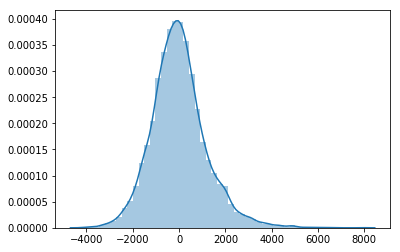

In [124]:
#### Assumption 2 : Normality of residuals:[using jarque berra test]:

from scipy import stats
print(stats.jarque_bera(model.resid))
print('chisquare stat critical',stats.chi2.isf(0.05,2))
# Framing hypothesis:
# H0- Errors/residual are normally distributed
# HA- Errors/residuals are not normally distributed
## from output of p value as p-val < alpha, we reject null hypothesis and accept alternate hypothesis.
# we can say that errors are not normally distributed with statistical certainty.
# Also, from JB statistic,we can see that it is much higher than 6,so it definitely lies in critical region,So,
# Reject null hypothesis there as well.
sns.distplot(model.resid)

(1.063389576282676, 0.022508622956259865)


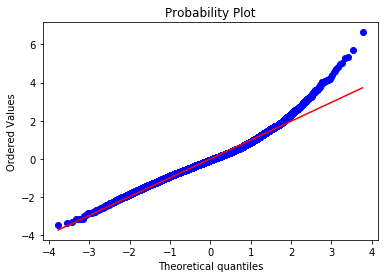

In [125]:
#### Assumption 3: Linearity of residuals:


import statsmodels.api as sm
print(sm.stats.diagnostic.linear_rainbow(res=model, frac=0.5))
# H0 -errors are linear 
# HA- errors are not linear
# So, p value < alpha ,we reject null hypothesis,i.e- errors/residual are not normal.
from statsmodels.graphics.gofplots import ProbPlot
import pylab
st_residual = model.get_influence().resid_studentized_internal
stats.probplot(st_residual, dist="norm", plot = pylab)
plt.show()

# Also,the graph shows plot is not following linearity.
# As, p value is less than alpha,we reject null hypothesis.So,we can say with statistical certainty that
# errors are not linear which means that linear models will not work efficiently.

In [126]:
#### Assumption 4 : homoscedastic

# H0- Data is homoscedastic [ constant variance across the data] 
# HA- Data is heteroscedastic [No constant variance across the data] 
from statsmodels.compat import lzip
import statsmodels.stats.api as sms
name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(model.resid, model.model.exog)
lzip(name, test)
# Since,P value > alpha ,we fail to reject null hypothesis.
# here,we can say that data is homoscedastic.

[('F statistic', 1.0216032240075512), ('p-value', 0.2430029954482895)]

In [127]:
#### Assumption 5- Multicollinearity:

from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = [variance_inflation_factor(Xc.values, i) for i in range(Xc.shape[1])]
pd.DataFrame({'vif': vif[1:]}, index=X.columns).T

## So,Multicollinearity does not exist.
## All the values of vif are below 5.So there is no multicollinearity

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
vif,1.002198,1.022403,1.064632,1.022478,1.001931,4.148537,1.081894,1.714448,5.865029,2.646478


## All label encoded with model building:

In [ ]:
df1=df.copy()
df1.drop('Item_Identifier',1,inplace=True)
### Converting Incorrect classes,typos into same class in df1.
df1['Item_Fat_Content'].replace({'LF':'Low Fat','low fat':'Low Fat','reg':'Regular'},inplace=True)

#### Treatment of missing values by median/most_frequent:

In [29]:
from sklearn.impute import SimpleImputer
si=SimpleImputer(missing_values=np.nan, strategy='median')
sicate=SimpleImputer(missing_values=np.nan, strategy='most_frequent')
for i in df1.select_dtypes(include='object'):
    if df1[i].isnull().sum()>0:
        df1[i]=sicate.fit_transform(np.array(df1[i]).reshape(-1,1))
for i in df1.select_dtypes(exclude='object'):
    if df1[i].isnull().sum()>0:
        df1[i]=si.fit_transform(np.array(df1[i]).reshape(-1,1))

In [30]:
## Label encoding
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
for i in df1.select_dtypes(include='object'):
    df1[i]=le.fit_transform(df1[i])

In [ ]:
X=df1.drop('Item_Outlet_Sales',1)
y=df1['Item_Outlet_Sales']

In [58]:
## This is temporary checking:
X=df1.drop('Item_Outlet_Sales',1)
y=df1['Item_Outlet_Sales']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state =0)
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
dt = DecisionTreeRegressor()
dt_params = {'max_depth':np.arange(1,10), 'min_samples_leaf':np.arange(2,30)}
rscv = RandomizedSearchCV(dt, dt_params, cv=5)
rscv.fit(X, y)
print(rscv.best_params_)
rscv_best_DT=rscv.best_params_
DT=DecisionTreeRegressor(**rscv_best_DT)
DT.fit(X_train,y_train)

In [38]:
y_pred=DT.predict(X_test)

In [48]:
print('r2 score:',r2_score(y_test,y_pred));print('RMSE:',np.sqrt(mean_squared_error(y_test,y_pred)))

r2 score: 0.5841152849505304
RMSE: 1103.2842378715563


#### Test data manipulations for label encoding:

In [51]:
dfte=pd.read_csv('D:/datasets+minipro/analytics vidhya datasets/bigmart sale/test_AbJTz2l.csv')
df2=dfte.copy()
df2.drop('Item_Identifier',1,inplace=True)
df2['Item_Fat_Content'].replace({'LF':'Low Fat','low fat':'Low Fat','reg':'Regular'},inplace=True)
from sklearn.impute import SimpleImputer
si=SimpleImputer(missing_values=np.nan, strategy='median')
sicate=SimpleImputer(missing_values=np.nan, strategy='most_frequent')
for i in df2.select_dtypes(include='object'):
    if df2[i].isnull().sum()>0:
        df2[i]=sicate.fit_transform(np.array(df2[i]).reshape(-1,1))
for i in df2.select_dtypes(exclude='object'):
    if df2[i].isnull().sum()>0:
        df2[i]=si.fit_transform(np.array(df2[i]).reshape(-1,1))
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
for i in df2.select_dtypes(include='object'):
    df2[i]=le.fit_transform(df2[i])

##### Using Linear Regression:[For all label encoded]

In [57]:
lr=LinearRegression()
lr.fit(X,y)
y_test_pred_lr=lr.predict(df2)
finalpred=pd.concat([dfte[['Item_Identifier','Outlet_Identifier']],pd.DataFrame(y_test_pred_lr,columns=['Item_Outlet_Sales'])],1)
finalpred.to_csv("D:/datasets+minipro/analytics vidhya datasets/bigmart sale/bigmartsalepredictionnew/rscvdt.csv",index=False)

##### Using DT Regression:[For all label encoded]:

In [59]:
X=df1.drop('Item_Outlet_Sales',1)
y=df1['Item_Outlet_Sales']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state =0)
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
dt = DecisionTreeRegressor()
dt_params = {'max_depth':np.arange(1,10), 'min_samples_leaf':np.arange(2,30)}
rscv = RandomizedSearchCV(dt, dt_params, cv=5)
rscv.fit(X, y)
print(rscv.best_params_)
rscv_best_DT=rscv.best_params_
DT=DecisionTreeRegressor(**rscv_best_DT)
DT.fit(X_train,y_train)

{'min_samples_leaf': 17, 'max_depth': 6}


DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=6,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=17, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [71]:
DT=DecisionTreeRegressor(**{'min_samples_leaf': 4, 'max_depth': 5})
DT.fit(X,y)
y_test_pred_DT=DT.predict(df2)
finalpred=pd.concat([dfte[['Item_Identifier','Outlet_Identifier']],pd.DataFrame(y_test_pred_DT,columns=['Item_Outlet_Sales'])],1)
finalpred.to_csv("D:/datasets+minipro/analytics vidhya datasets/bigmart sale/bigmartsalepredictionnew/rscvDT.csv",index=False)
### 1167 using {'min_samples_leaf': 17, 'max_depth': 6}
### 1166 using {'min_samples_leaf': 11, 'max_depth': 6}
###  1159 using {'min_samples_leaf': 4, 'max_depth': 5})

##### Using Random Forest:[For all label encoded]

In [74]:
rf_params = {
    'bootstrap': [True],
    'max_depth': [3,10],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10],
    'n_estimators': [100, 200]}
rf=RandomForestRegressor()
rscv_rf = RandomizedSearchCV(rf, rf_params, cv=3)
rscv_rf.fit(X, y)
print(rscv_rf.best_params_)
rscv_rf_best_rf=rscv_rf.best_params_

## 1161 RMSE={'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 3, 'max_depth': 10, 'bootstrap': True}
### 1161 RMSE={'n_estimators': 100, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': 3, 'max_depth': 10, 'bootstrap': True}
### 1161 Gridsearch :{'bootstrap': True, 'max_depth': 10, 'max_features': 3, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}

{'bootstrap': True, 'max_depth': 10, 'max_features': 3, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}


In [75]:
rf=RandomForestRegressor(**rscv_rf_best_rf)
rf.fit(X,y)
y_test_pred_rf=rf.predict(df2)
finalpred=pd.concat([dfte[['Item_Identifier','Outlet_Identifier']],pd.DataFrame(y_test_pred_rf,columns=['Item_Outlet_Sales'])],1)
finalpred.to_csv("D:/datasets+minipro/analytics vidhya datasets/bigmart sale/bigmartsalepredictionnew/rscvrf.csv",index=False)

## All get_dummies:

In [103]:
df3=df.copy()
df3.drop('Item_Identifier',1,inplace=True)
df3['Item_Fat_Content'].replace({'LF':'Low Fat','low fat':'Low Fat','reg':'Regular'},inplace=True)

#### Treatment of missing values by median/most_frequent:

In [104]:
from sklearn.impute import SimpleImputer
si=SimpleImputer(missing_values=np.nan, strategy='median')
sicate=SimpleImputer(missing_values=np.nan, strategy='most_frequent')
for i in df3.select_dtypes(include='object'):
    if df3[i].isnull().sum()>0:
        df3[i]=sicate.fit_transform(np.array(df3[i]).reshape(-1,1))
for i in df3.select_dtypes(exclude='object'):
    if df3[i].isnull().sum()>0:
        df3[i]=si.fit_transform(np.array(df3[i]).reshape(-1,1))

In [105]:
for i in df3.select_dtypes(include='object'):
    df3=pd.concat([df3,pd.get_dummies(df3[i],prefix=i,drop_first=True)],1)
    del df3[i]

#### Test data manipulation for dummies:

In [106]:
df4=dfte.copy()
df4.drop('Item_Identifier',1,inplace=True)
df4['Item_Fat_Content'].replace({'LF':'Low Fat','low fat':'Low Fat','reg':'Regular'},inplace=True)

In [107]:
from sklearn.impute import SimpleImputer
si=SimpleImputer(missing_values=np.nan, strategy='median')
sicate=SimpleImputer(missing_values=np.nan, strategy='most_frequent')
for i in df4.select_dtypes(include='object'):
    if df4[i].isnull().sum()>0:
        df4[i]=sicate.fit_transform(np.array(df4[i]).reshape(-1,1))
for i in df4.select_dtypes(exclude='object'):
    if df4[i].isnull().sum()>0:
        df4[i]=si.fit_transform(np.array(df4[i]).reshape(-1,1))
for i in df4.select_dtypes(include='object'):
    df4=pd.concat([df4,pd.get_dummies(df4[i],prefix=i,drop_first=True)],1)
    del df4[i]

In [110]:
X=df3.drop('Item_Outlet_Sales',1)
y=df3['Item_Outlet_Sales']

In [111]:
##### Using Linear Regression:[For all label encoded]
lr=LinearRegression()
lr.fit(X,y)
y_test_pred_lr=lr.predict(df4)
finalpred=pd.concat([dfte[['Item_Identifier','Outlet_Identifier']],pd.DataFrame(y_test_pred_lr,columns=['Item_Outlet_Sales'])],1)
finalpred.to_csv("D:/datasets+minipro/analytics vidhya datasets/bigmart sale/bigmartsalepredictionnew/rscvlr.csv",index=False)

In [114]:
##### Using DT Regression:[For all label encoded]:

X=df3.drop('Item_Outlet_Sales',1)
y=df3['Item_Outlet_Sales']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state =0)
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
dt = DecisionTreeRegressor()
dt_params = {'max_depth':np.arange(1,10), 'min_samples_leaf':np.arange(2,30)}
rscv = RandomizedSearchCV(dt, dt_params, cv=5)
rscv.fit(X, y)
print(rscv.best_params_)
rscv_best_DT=rscv.best_params_

DT=DecisionTreeRegressor(**{'min_samples_leaf': 4, 'max_depth': 5})
DT.fit(X,y)
y_test_pred_DT=DT.predict(df4)
finalpred=pd.concat([dfte[['Item_Identifier','Outlet_Identifier']],pd.DataFrame(y_test_pred_DT,columns=['Item_Outlet_Sales'])],1)
finalpred.to_csv("D:/datasets+minipro/analytics vidhya datasets/bigmart sale/bigmartsalepredictionnew/rscvDT.csv",index=False)

{'min_samples_leaf': 18, 'max_depth': 5}


In [115]:
##### Using Random Forest:[For all label encoded]

rf_params = {
    'bootstrap': [True],
    'max_depth': [3,10],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10],
    'n_estimators': [100, 200]}
rf=RandomForestRegressor()
rscv_rf = RandomizedSearchCV(rf, rf_params, cv=3)
rscv_rf.fit(X, y)
print(rscv_rf.best_params_)
rscv_rf_best_rf=rscv_rf.best_params_

rf=RandomForestRegressor(**rscv_rf_best_rf)
rf.fit(X,y)
y_test_pred_rf=rf.predict(df4)
finalpred=pd.concat([dfte[['Item_Identifier','Outlet_Identifier']],pd.DataFrame(y_test_pred_rf,columns=['Item_Outlet_Sales'])],1)
finalpred.to_csv("D:/datasets+minipro/analytics vidhya datasets/bigmart sale/bigmartsalepredictionnew/rscvrf.csv",index=False)

{'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 3, 'max_depth': 10, 'bootstrap': True}


#### So,Decision tree as a regressor is my best model with hyperparameter tuning and all label encoding.
#### It gives around 1159 rmse on AV platform.